In [25]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Islamophhobia Detection with BERT using Keras and TensorFlow 2

In [26]:
!nvidia-smi

Sun Sep 20 19:59:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    38W / 300W |    461MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [27]:
!pip install tensorflow-gpu 

In [28]:
!pip install --upgrade grpcio

Requirement already up-to-date: grpcio in /usr/local/lib/python3.6/dist-packages (1.32.0)


In [29]:
!pip install tqdm

In [30]:
!pip install bert-for-tf2

In [31]:
!pip install googletrans

In [32]:
!pip install sentencepiece

In [33]:
!pip install googletrans

In [34]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

import re

# translator
import googletrans
from googletrans import Translator

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Data


In [35]:
# Hindi data
!gdown --id 1EQRLvSUJn6VxFluTqNEGxXcV8_5OmCaW --output data-task3.csv

Downloading...
From: https://drive.google.com/uc?id=1EQRLvSUJn6VxFluTqNEGxXcV8_5OmCaW
To: /content/data-task3.csv
100% 1.63M/1.63M [00:00<00:00, 109MB/s]


In [36]:
df = pd.read_csv('data-task3.csv', 
                   delimiter=',')
df.columns = ['Text', 'Label']
df.head(15)
df["Text"] = df["Text"].astype(str)
df["Label"] = df["Label"].astype(str)

In [37]:
df.Text[3]

"'अमीन के 500 से अधिक छात्रों ने सर्वे भवन के गेट पर आधा नंगा होकर किया प्रदर्शन  पप्पू यादव ने बुलंद की\\xa0आवाज"

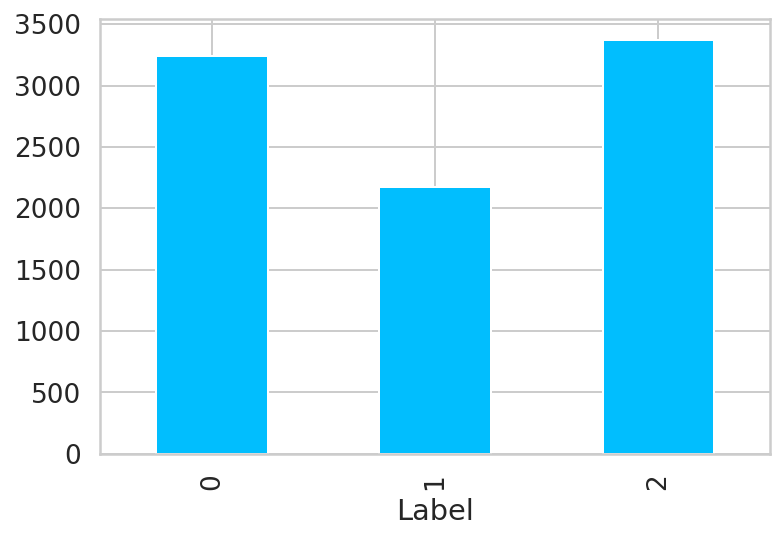

In [38]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
df.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [39]:

# For entire dataset sentences for each labels 
df.Label.value_counts()

2    3375
0    3244
1    2174
Name: Label, dtype: int64

In [40]:
#balancing data 
from collections import Counter
import numpy as np
def balanceClasses(xs, ys):
    item = {}
    new_ys = []
    new_xs = []
    #"""Undersample xs, ys to balance classes."""
    freqs = Counter(ys)
    # the most common class  is the maximum number we want for all classes
    max_allowable = (freqs.most_common()[0][1])
    
    for val in freqs.most_common(): # List
        nums = np.random.randint(1000)
        i = 1
        item[val[0]] = max_allowable - val[1]
        
        if item[val[0]] > 0:            
            while(item[val[0]] - i != 0): 
                nums = nums + 1
                if ys[nums] == val[0]:
                    i += 1
                    new_ys.append(ys[nums])
                    new_xs.append(xs[nums])
    return new_xs, new_ys

In [41]:
new_text, new_label = balanceClasses(df['Text'], df['Label'])

In [42]:
data_df = pd.DataFrame(new_text)
data_df.columns = ['Text']
data_df['Label'] = new_label
data_df = pd.concat([df, data_df])

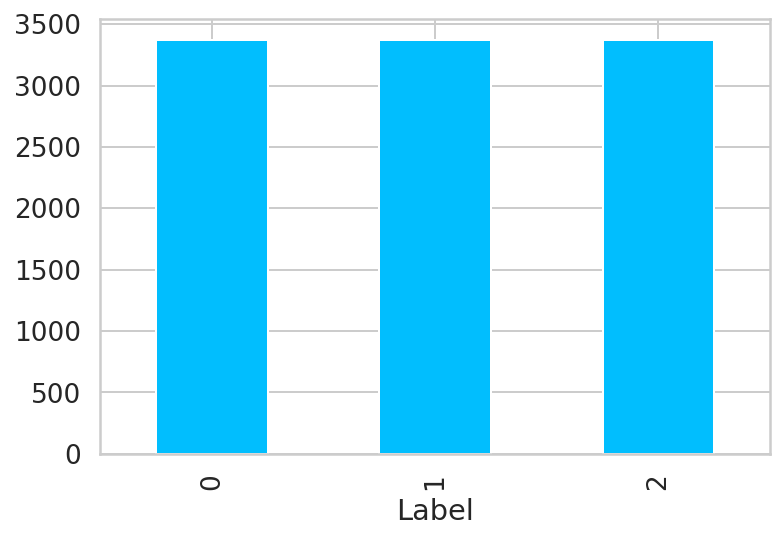

In [43]:
fig1 = plt.figure(figsize=(6,4))
data_df.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [44]:
df = data_df

In [45]:
df.Label.value_counts()

2    3375
1    3374
0    3374
Name: Label, dtype: int64

In [46]:
df=df.sample(frac=1).reset_index(drop=True)
df

,Text,Label
0,'@BushraAnjum_ मेरी तरफ से आपको बहुत-बहुत तहे ...,1
1,'@kpmaurya1 नारी शक्ति जिंदाबाद जिंदाबाद,0
2,'जेहादी सोच थी उसकी कोई शायर का काम थोड़ी था।...,2
3,'@naaz786nice जुम्मा के दिन नमाज़ में ऐसे लोगो...,1
4,'अब खुब जमेगा रंग जब मिल बैठेंगे तीन यार संग। ...,0
...,...,...
10118,'@aschandailBJP शानदार👏 जिंदाबाद भइया,0
10119,@Swamy29 सर वीडियो बन गया हैं जल्दी उपलोड कर ...,2
10120,'तस्वीरों में देखें कैसे रांची के राजकुमार बन...,0
10121,'@ZeeNewsHindi हज़ारों मुसलमानों ने रमज़ान में...,1


In [48]:
df = df[df.Text != '']

In [49]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.10, random_state=42)

In [50]:
df.head()

,Text,Label
0,'@BushraAnjum_ मेरी तरफ से आपको बहुत-बहुत तहे ...,1
1,'@kpmaurya1 नारी शक्ति जिंदाबाद जिंदाबाद,0
2,'जेहादी सोच थी उसकी कोई शायर का काम थोड़ी था।...,2
3,'@naaz786nice जुम्मा के दिन नमाज़ में ऐसे लोगो...,1
4,'अब खुब जमेगा रंग जब मिल बैठेंगे तीन यार संग। ...,0


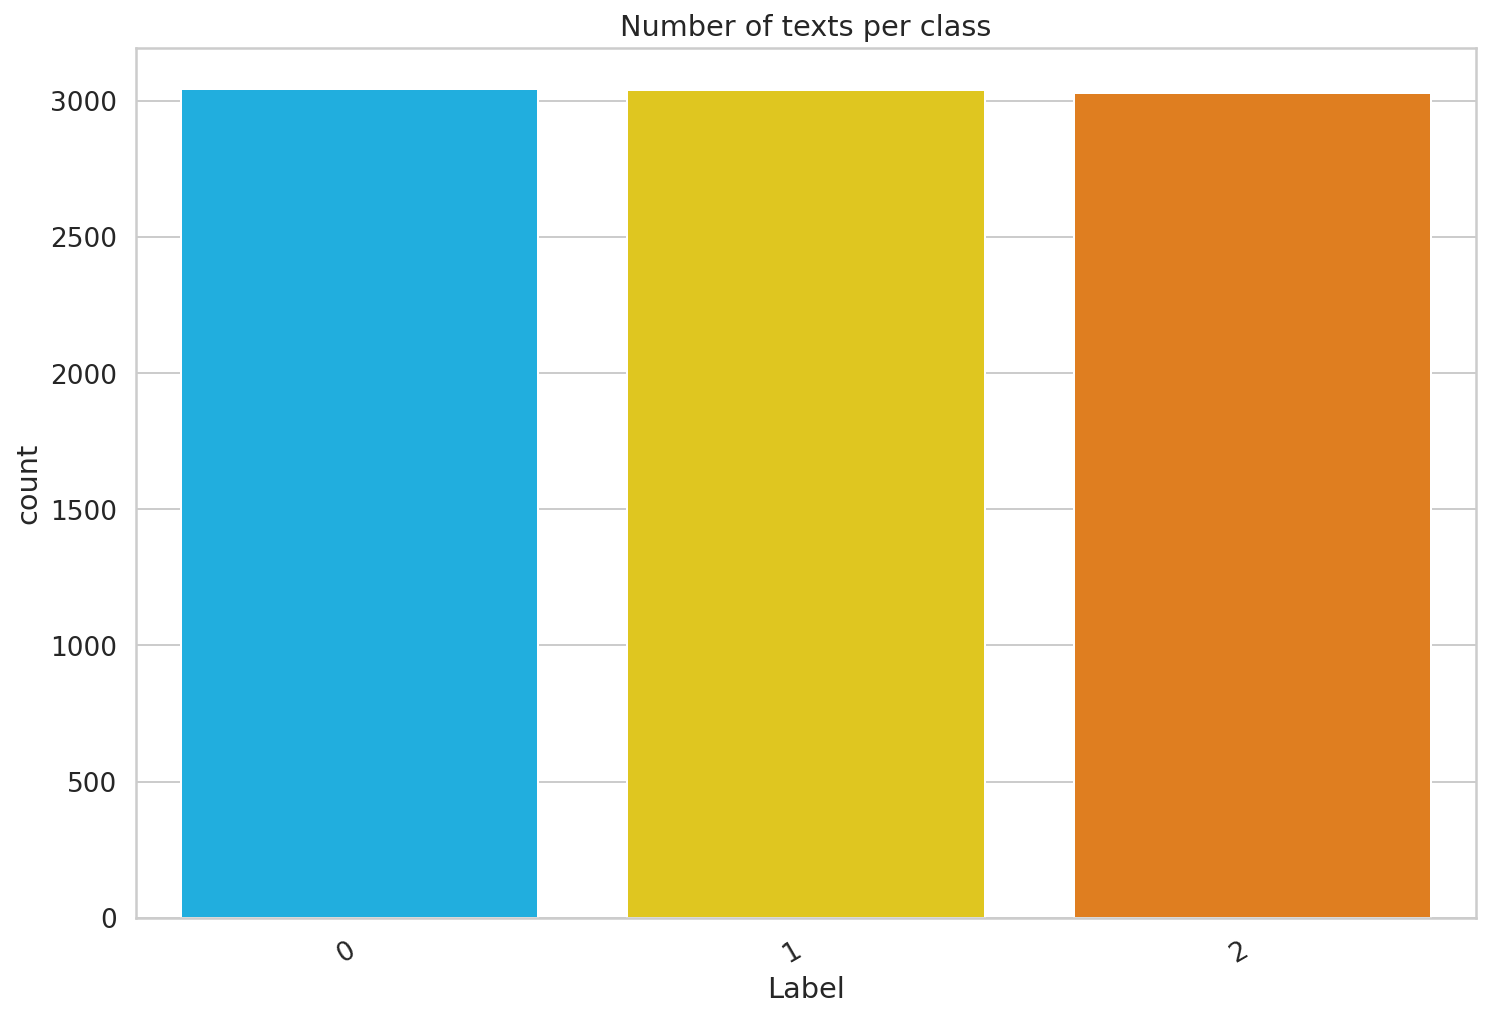

In [51]:
chart = sns.countplot(train.Label, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per class")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

# Islamophhobia Detection with BERT


In [52]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2020-09-20 20:01:32--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip.1’

uncased_L-12_H-768_ 100%[===================>] 388.84M   111MB/s    in 3.5s    

2020-09-20 20:01:36 (111 MB/s) - ‘uncased_L-12_H-768_A-12.zip.1’ saved [407727028/407727028]



In [53]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [54]:
os.makedirs("model", exist_ok=True)

In [55]:
!mv uncased_L-12_H-768_A-12/ model

mv: cannot move 'uncased_L-12_H-768_A-12/' to 'model/uncased_L-12_H-768_A-12': Directory not empty


In [56]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

## Preprocessing

In [57]:
class IslamophobiaDetectionData:
  DATA_COLUMN = "Text"
  LABEL_COLUMN = "Label"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[IslamophobiaDetectionData.DATA_COLUMN], row[IslamophobiaDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [58]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [59]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  #print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)

  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)


  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
  
  model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)
        
  return model

## Training

In [60]:
classes = train.Label.unique().tolist()

data = IslamophobiaDetectionData(train, test, tokenizer, classes, max_seq_len=128)

9110it [00:03, 2286.50it/s]
1013it [00:00, 2229.77it/s]


max seq_len 225


In [61]:
model = create_model(data.max_seq_len, bert_ckpt_file)

Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fd8b7c683c8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [62]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 768)          108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                

In [63]:


history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=5
)

Epoch 1/5
513/513 [==============================] - 127s 248ms/step - loss: 0.8086 - acc: 0.7223 - val_loss: 0.6444 - val_acc: 0.9045
Epoch 2/5
513/513 [==============================] - 125s 245ms/step - loss: 0.6202 - acc: 0.9315 - val_loss: 0.6215 - val_acc: 0.9297
Epoch 3/5
513/513 [==============================] - 126s 245ms/step - loss: 0.6122 - acc: 0.9390 - val_loss: 0.6144 - val_acc: 0.9363
Epoch 4/5
513/513 [==============================] - 126s 245ms/step - loss: 0.6101 - acc: 0.9410 - val_loss: 0.6190 - val_acc: 0.9308
Epoch 5/5
513/513 [==============================] - 125s 244ms/step - loss: 0.6096 - acc: 0.9410 - val_loss: 0.6193 - val_acc: 0.9308


## Evaluation

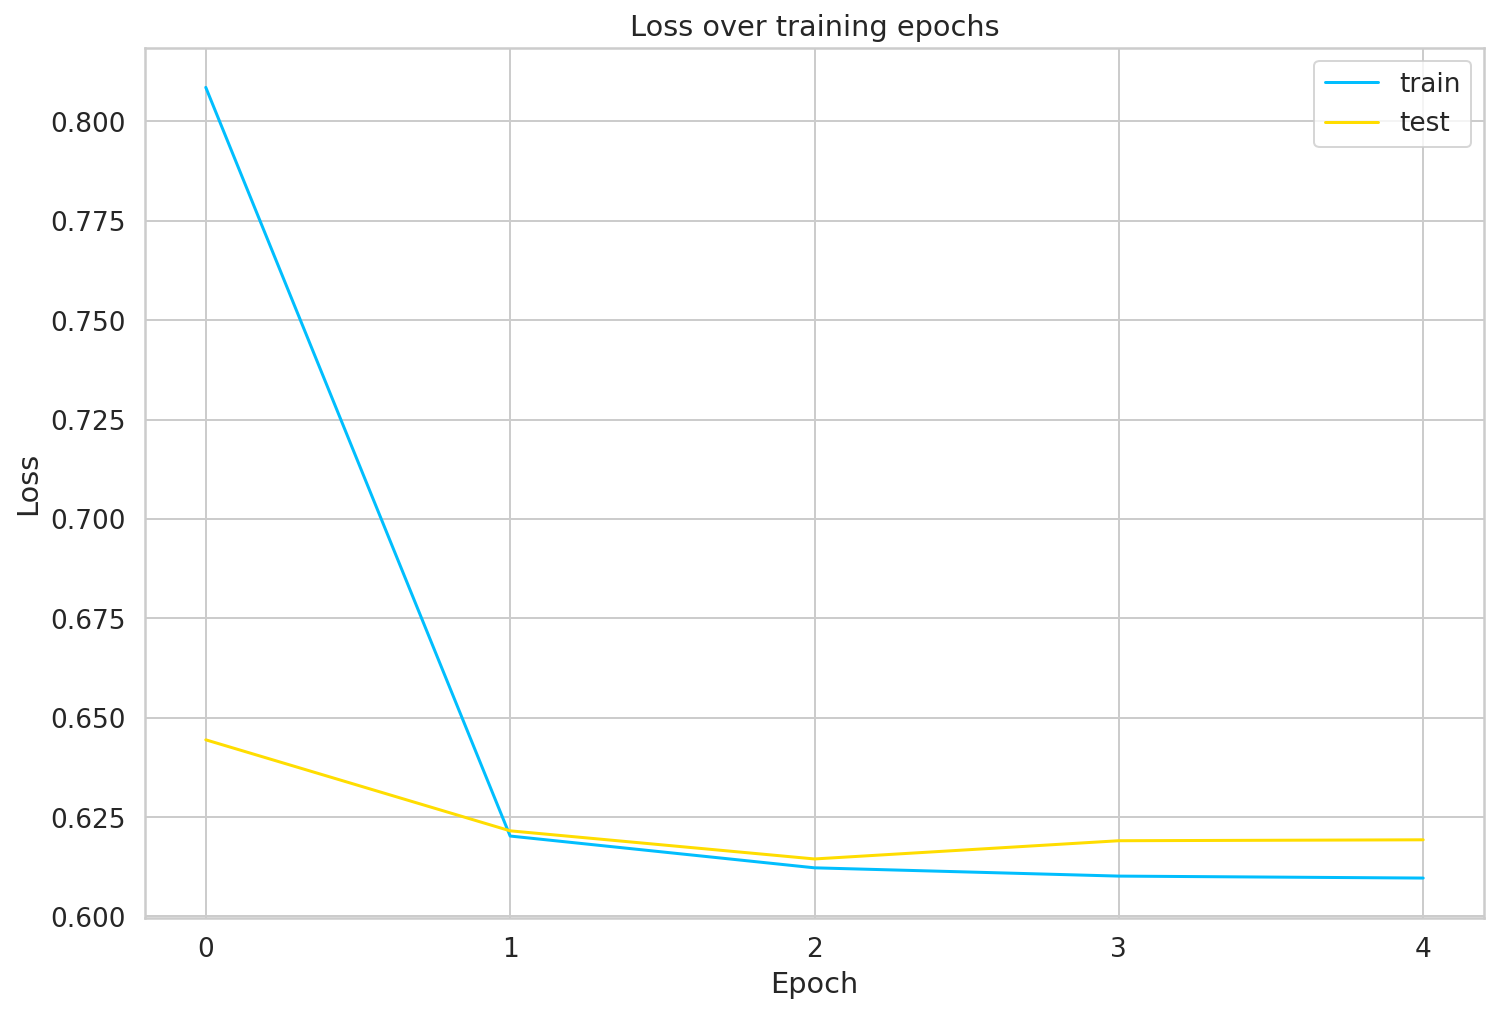

In [64]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

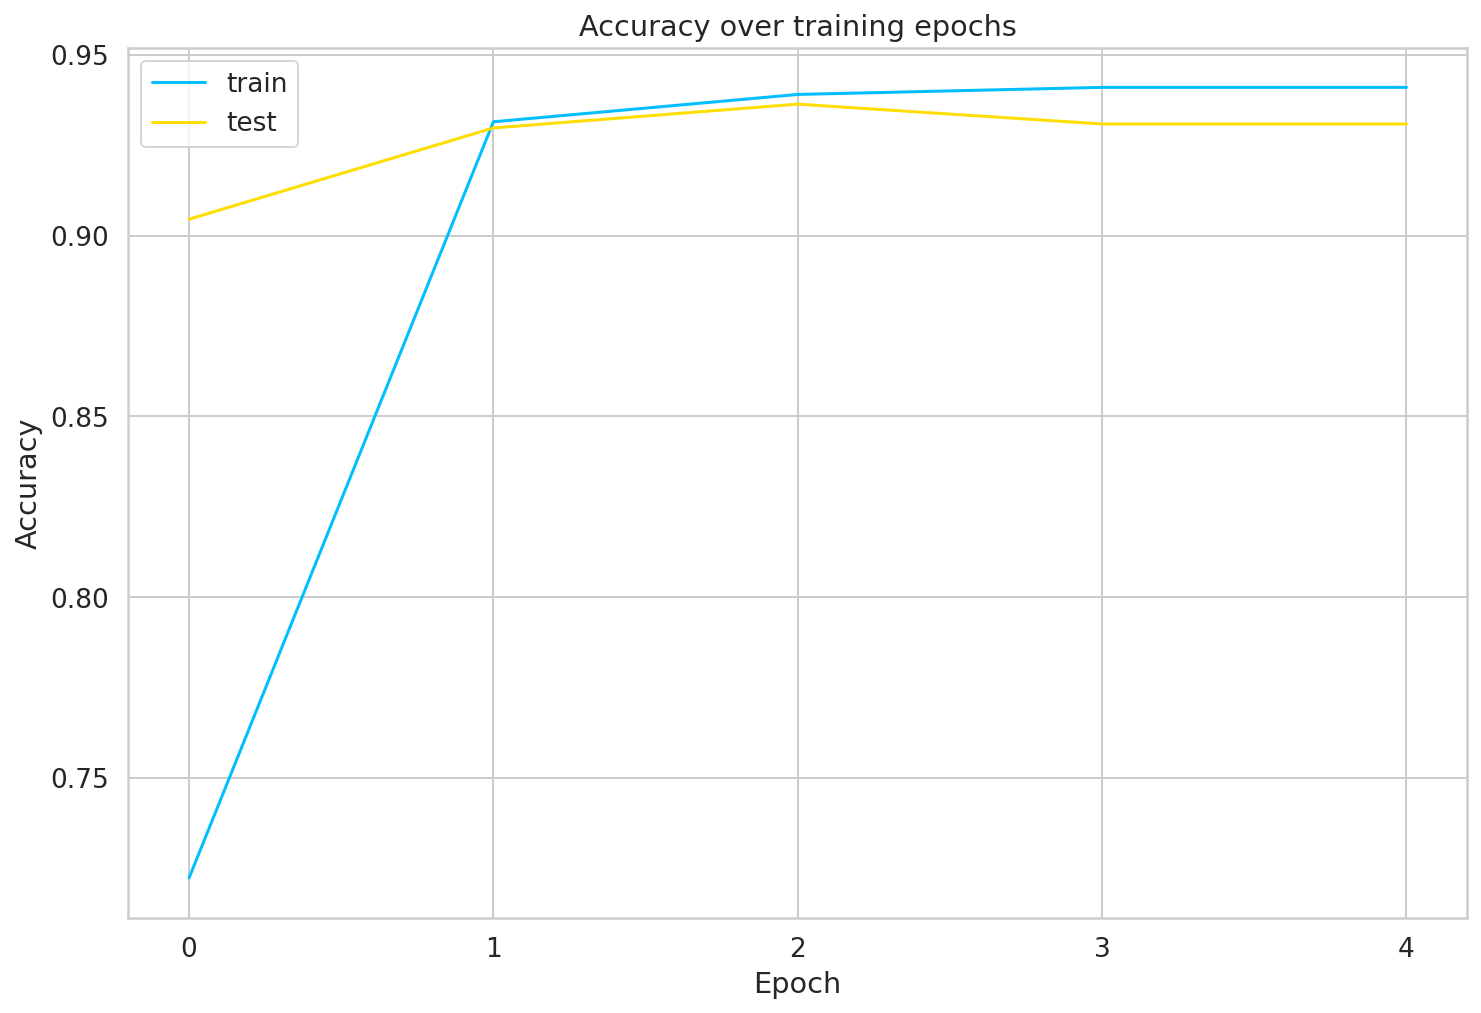

In [65]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

In [66]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

32/32 [==============================] - 3s 103ms/step - loss: 0.6167 - acc: 0.9339
train acc 0.9468715786933899
test acc 0.9338598251342773


In [67]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [68]:
print(classification_report(data.test_y, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       336
           1       0.97      0.92      0.94       332
           2       0.96      0.93      0.94       345

    accuracy                           0.93      1013
   macro avg       0.94      0.93      0.93      1013
weighted avg       0.94      0.93      0.93      1013



In [69]:

cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

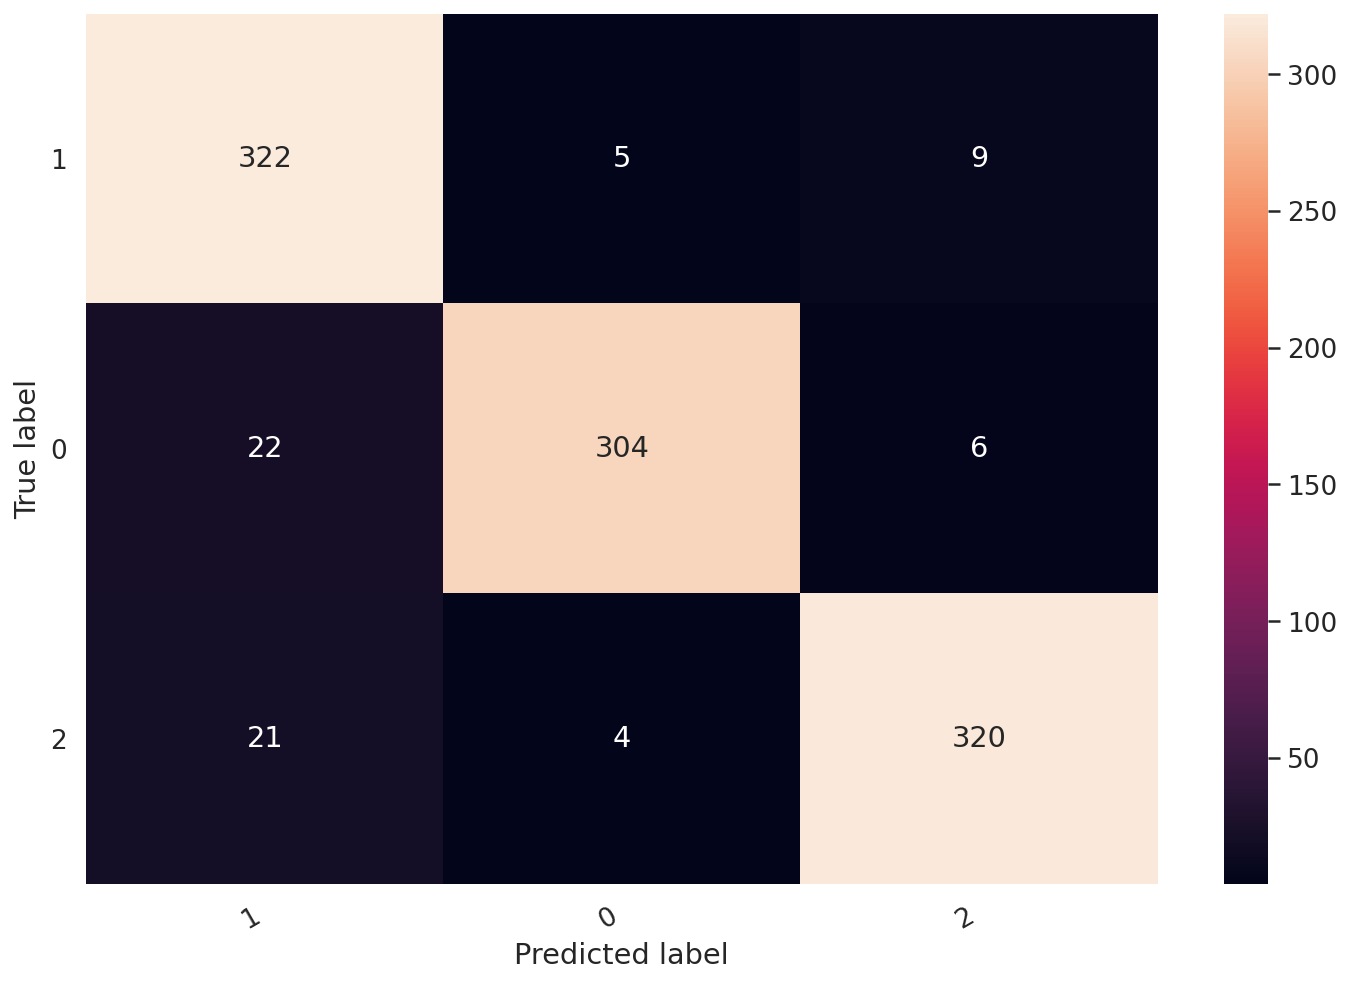

In [70]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

# 10 Fold cross validation

In [71]:
import random
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

kFold = 10

#To get accuracy of the model for 10 different splits
scores = []
training_accuracy = []
testing_accuracy = []
print("BERT: ")
for i in range(kFold):
    print('Fold ', i+1)
    print('')
    # Splitting data into test and train
    train, test = train_test_split(df, test_size=0.10, shuffle = True)

    classes = train.Label.unique().tolist()
    data = IslamophobiaDetectionData(train, test, tokenizer, classes, max_seq_len=128)
    model = create_model(data.max_seq_len, bert_ckpt_file)
    history = model.fit( x=data.train_x, y=data.train_y,validation_split=0.1,batch_size=16, shuffle=True,epochs=5)
    #train_loss, train_acc = model.evaluate(data.train_x, data.train_y)
    test_loss, test_acc = model.evaluate(data.test_x, data.test_y)
    
    #training_accuracy.append(train_acc)
    testing_accuracy.append(test_acc)

    y_pred = model.predict(data.test_x).argmax(axis=-1)

    scoreValue =accuracy_score(data.test_y, y_pred)
    scores.append(scoreValue)


243it [00:00, 2420.07it/s]

BERT: 
Fold  1



9110it [00:04, 2270.50it/s]
1013it [00:00, 2226.64it/s]


max seq_len 225
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fd76ae483c8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
513/513 [==============================] - 130s 253ms/step - loss: 0.8208 - acc: 0.7081 - val_loss: 0.6120 - val_acc: 0.9385
Epoch 2/5
513/513 [==============================] - 127s 247ms/step - loss: 0.6229 - acc: 0.9280 - val_loss: 0.6086 - val_acc: 0.9418
Epoch 3/5
513/513 [==============================] - 126s 246ms/step - loss

219it [00:00, 2181.14it/s]

Fold  2



9110it [00:04, 1981.38it/s]
1013it [00:00, 2272.05it/s]


max seq_len 225
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fd763f0c8d0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
513/513 [==============================] - 132s 257ms/step - loss: 0.8425 - acc: 0.6820 - val_loss: 0.6188 - val_acc: 0.9341
Epoch 2/5
513/513 [==============================] - 129s 251ms/step - loss: 0.6226 - acc: 0.9283 - val_loss: 0.6149 - val_acc: 0.9341
Epoch 3/5
513/513 [==============================] - 129s 252ms/step - loss

196it [00:00, 1956.17it/s]

Fold  3



9110it [00:04, 2229.56it/s]
1013it [00:00, 2272.96it/s]


max seq_len 225
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fd7631cd2b0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
513/513 [==============================] - 130s 253ms/step - loss: 0.7816 - acc: 0.7534 - val_loss: 0.6253 - val_acc: 0.9232
Epoch 2/5
513/513 [==============================] - 126s 247ms/step - loss: 0.6189 - acc: 0.9318 - val_loss: 0.6188 - val_acc: 0.9319
Epoch 3/5
513/513 [==============================] - 127s 247ms/step - loss

237it [00:00, 2361.21it/s]

Fold  4



9110it [00:03, 2312.14it/s]
1013it [00:00, 2298.93it/s]


max seq_len 225
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fd761cafb00> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
513/513 [==============================] - 131s 255ms/step - loss: 0.8749 - acc: 0.6493 - val_loss: 0.6042 - val_acc: 0.9451
Epoch 2/5
513/513 [==============================] - 128s 250ms/step - loss: 0.6217 - acc: 0.9289 - val_loss: 0.5986 - val_acc: 0.9517
Epoch 3/5
513/513 [==============================] - 128s 250ms/step - loss

235it [00:00, 2347.65it/s]

Fold  5



9110it [00:03, 2310.46it/s]
1013it [00:00, 2298.07it/s]


max seq_len 225
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fd8911692b0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
513/513 [==============================] - 130s 253ms/step - loss: 0.8366 - acc: 0.6946 - val_loss: 0.6681 - val_acc: 0.8814
Epoch 2/5
513/513 [==============================] - 127s 247ms/step - loss: 0.6268 - acc: 0.9238 - val_loss: 0.6266 - val_acc: 0.9254
Epoch 3/5
513/513 [==============================] - 127s 247ms/step - loss

229it [00:00, 2286.42it/s]

Fold  6



9110it [00:03, 2301.12it/s]
1013it [00:00, 2255.54it/s]


max seq_len 225
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fd89114e7b8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
513/513 [==============================] - 131s 255ms/step - loss: 0.8064 - acc: 0.7292 - val_loss: 0.6336 - val_acc: 0.9177
Epoch 2/5
513/513 [==============================] - 128s 250ms/step - loss: 0.6193 - acc: 0.9316 - val_loss: 0.6341 - val_acc: 0.9144
Epoch 3/5
513/513 [==============================] - 128s 249ms/step - loss

237it [00:00, 2359.98it/s]

Fold  7



9110it [00:03, 2312.82it/s]
1013it [00:00, 2302.99it/s]


max seq_len 225
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fd76bcf6400> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
513/513 [==============================] - 130s 254ms/step - loss: 0.7994 - acc: 0.7353 - val_loss: 0.6166 - val_acc: 0.9330
Epoch 2/5
513/513 [==============================] - 127s 248ms/step - loss: 0.6207 - acc: 0.9308 - val_loss: 0.6016 - val_acc: 0.9484
Epoch 3/5
513/513 [==============================] - 128s 249ms/step - loss

238it [00:00, 2378.63it/s]

Fold  8



9110it [00:03, 2286.88it/s]
1013it [00:00, 2333.40it/s]


max seq_len 225
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fd7603d8940> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
513/513 [==============================] - 130s 254ms/step - loss: 0.8383 - acc: 0.6894 - val_loss: 0.6122 - val_acc: 0.9396
Epoch 2/5
513/513 [==============================] - 127s 248ms/step - loss: 0.6207 - acc: 0.9305 - val_loss: 0.6060 - val_acc: 0.9429
Epoch 3/5
513/513 [==============================] - 128s 249ms/step - loss

233it [00:00, 2327.02it/s]

Fold  9



9110it [00:03, 2301.59it/s]
1013it [00:00, 2401.11it/s]


max seq_len 225
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fd619b56d30> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
513/513 [==============================] - 131s 255ms/step - loss: 0.8028 - acc: 0.7317 - val_loss: 0.6266 - val_acc: 0.9243
Epoch 2/5
513/513 [==============================] - 127s 248ms/step - loss: 0.6211 - acc: 0.9297 - val_loss: 0.6226 - val_acc: 0.9276
Epoch 3/5
513/513 [==============================] - 128s 249ms/step - loss

240it [00:00, 2395.70it/s]

Fold  10



9110it [00:03, 2332.14it/s]
1013it [00:00, 2262.89it/s]


max seq_len 225
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fd65d7f95c0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
513/513 [==============================] - 129s 252ms/step - loss: 0.8272 - acc: 0.7022 - val_loss: 0.6214 - val_acc: 0.9297
Epoch 2/5
513/513 [==============================] - 127s 247ms/step - loss: 0.6214 - acc: 0.9296 - val_loss: 0.6117 - val_acc: 0.9385
Epoch 3/5
513/513 [==============================] - 127s 248ms/step - loss

In [72]:

print('')
Mean_score = sum(scores) / len(scores)
print(f" Mean predict: {Mean_score}" )

mean_test = sum(testing_accuracy)/len(testing_accuracy)
print(f" Mean testing accuracy for 10 folds: {mean_test}" )


 Mean predict: 0.9396841066140176
 Mean testing accuracy for 10 folds: 0.9396841049194335


In [75]:
translator = Translator()
sentences = []
# 1
hin_text =  "इसलाम सुंदर है"
sentences.append(hin_text)

trans = translator.translate(hin_text, dest='en')

sentences.append(trans.text)

# 0
hin_text =  " समाज वादी  पार्टी  जिंदाबाद "
sentences.append(hin_text)

trans = translator.translate(hin_text, dest='en')

sentences.append(trans.text)

# 2
hin_text =  "'गाजा में दीवाली   की ढेरो बधाई मित्रो 😊💐  #IsraeliBombing 😂😂"
sentences.append(hin_text)

trans = translator.translate(hin_text, dest='en')

sentences.append(trans.text)

# 2
hin_text = "UK ने भारत को लुटा था अब जिहादी UK को लुटने पोहँच गए। जो करोगे सो भरोगे।"
sentences.append(hin_text)

trans = translator.translate(hin_text, dest='en')

sentences.append(trans.text)

# 2
sentences.append( "Play our song now you asshole jehadi muslim")

# 0
sentences.append( "Rate this book as awful")


pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
  print("text:", text, "\nLabel:", classes[label])
  print()

text: इसलाम सुंदर है 
Label: 1

text: Islam is beautiful 
Label: 2

text:  समाज वादी  पार्टी  जिंदाबाद  
Label: 0

text: Samajwadi Party Zindabad 
Label: 2

text: 'गाजा में दीवाली   की ढेरो बधाई मित्रो 😊💐  #IsraeliBombing 😂😂 
Label: 0

text: 'Happy Diwali greetings in Gaza Friends 😊💐 #IsraeliBombing 😂😂 
Label: 2

text: UK ने भारत को लुटा था अब जिहादी UK को लुटने पोहँच गए। जो करोगे सो भरोगे। 
Label: 2

text: The UK had looted India, now the jihadis looted the UK. Whatever you do will be filled. 
Label: 2

text: Play our song now you asshole jehadi muslim 
Label: 2

text: Rate this book as awful 
Label: 1



# Reference

1. Movie Reviews with bert-for-tf2 https://colab.research.google.com/drive/1esTDT7S7-31Uiwr8Hj1meV1aokeo8AYX?authuser=1